In [1]:
1

1

In [2]:
import scanpy as sc
import os
import random
import pickle
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [3]:
data_output_dir  = "/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/similarities"

In [4]:
output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/figures/pbmc/data/cytokine_similarity"

In [5]:
with open("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/cyto_to_fam.pkl", "rb") as file:
    cyto_to_family = pickle.load(file)


In [6]:
with open("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/donor_cytokine_displacements.pkl", "rb") as file:
    donor_cytokine_displacements = pickle.load(file)


In [7]:
donor_order = [f"Donor{i}" for i in range(1,13)]

In [8]:
cytos = cyto_to_family.keys()
df_cytokine_sim = pd.DataFrame(index=cytos, columns=cytos)
for c1 in cytos:
    for c2 in cytos:
        repr_c1 = np.concatenate([donor_cytokine_displacements[donor][c1] for donor in donor_order], axis=1)
        repr_c2 = np.concatenate([donor_cytokine_displacements[donor][c2] for donor in donor_order], axis=1)
        df_cytokine_sim.loc[c1, c2] = cosine_similarity(np.asarray(repr_c1), np.asarray(repr_c2))[0][0]
df_cytokine_sim = df_cytokine_sim.astype("float")

In [9]:
df_cytokine_sim.to_csv(os.path.join(data_output_dir, "df_cytokine_sim.csv"))

<Figure size 1200x1200 with 0 Axes>

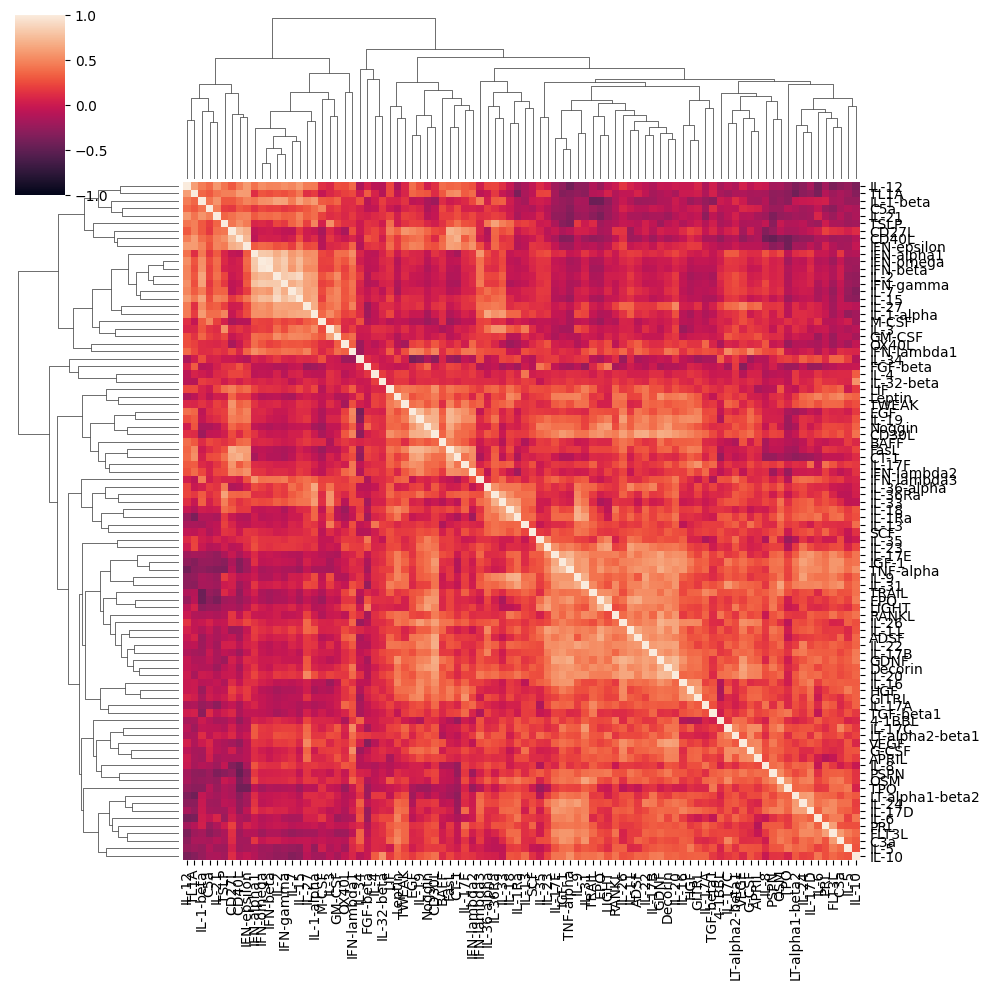

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size and style
plt.figure(figsize=(12, 12))  # Adjust width and height as needed

# Create the heatmap
clustermap = sns.clustermap(
    df_cytokine_sim,
    vmin=-1,
    vmax=1,
    xticklabels=True,  # Ensure all x-axis labels are shown
    yticklabels=True,  # Ensure all y-axis labels are shown
    
)




In [11]:
row_order = clustermap.dendrogram_row.reordered_ind
col_order = clustermap.dendrogram_col.reordered_ind
row_order == col_order
cyto_order = df_cytokine_sim.index[row_order]
with open("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/cyto_order.pkl", "wb") as file:
    pickle.dump(cyto_order, file)

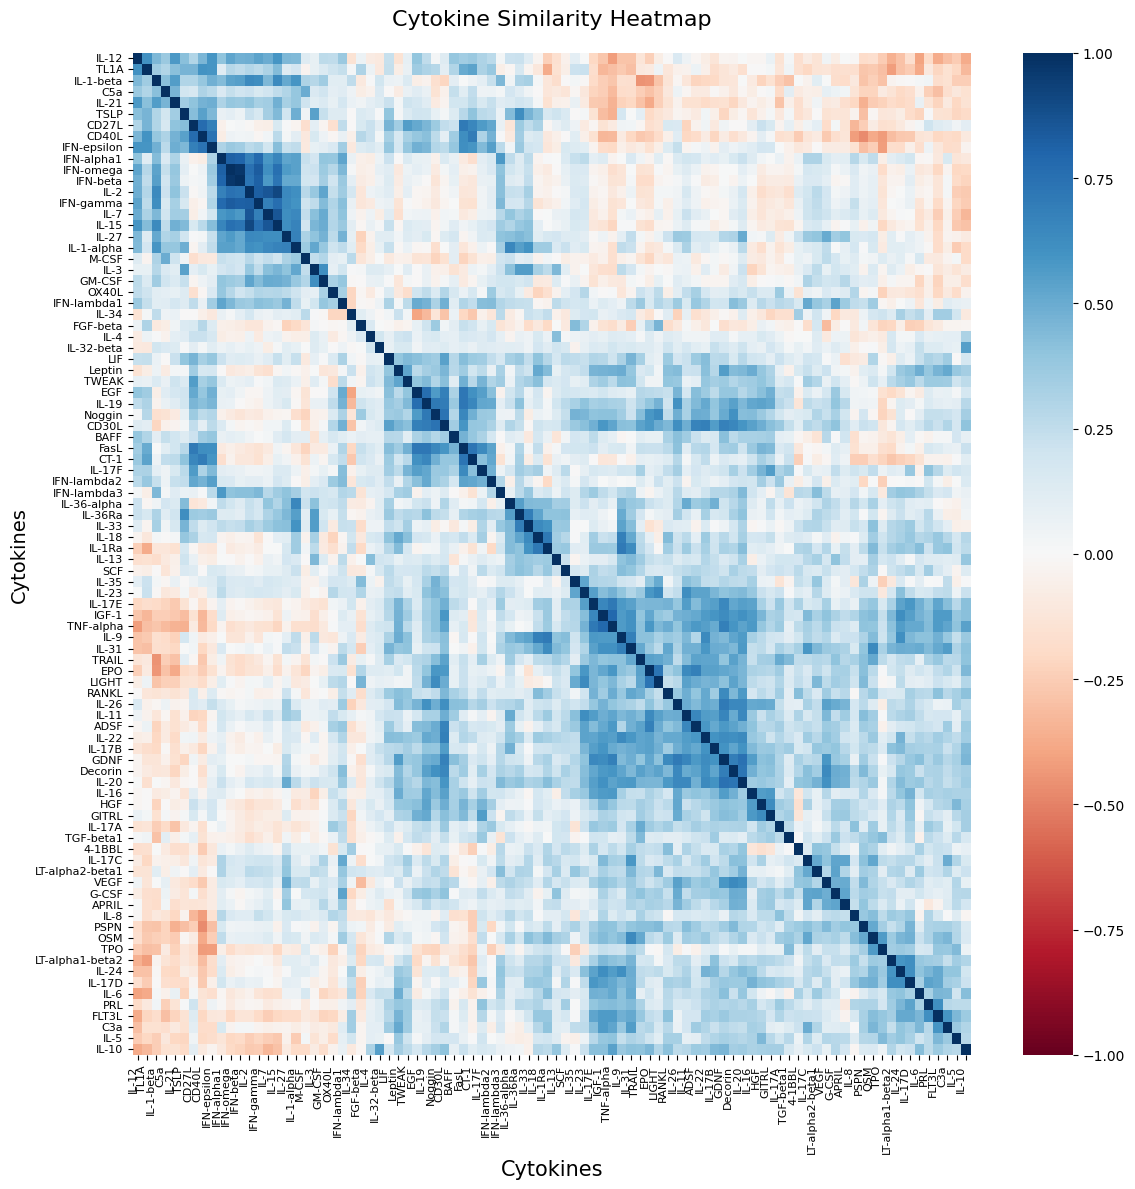

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Set the figure size
plt.figure(figsize=(12, 12))

# Create the heatmap
heatmap = sns.heatmap(
    df_cytokine_sim.loc[cyto_order, cyto_order],
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,  # Ensure all x-axis labels are shown
    yticklabels=True,  # Ensure all y-axis labels are shown
)

# Add titles and labels
plt.title("Cytokine Similarity Heatmap", fontsize=16, pad=20)
plt.xlabel("Cytokines", fontsize=15)
plt.ylabel("Cytokines", fontsize=14)

# Get the tick labels
xticklabels = heatmap.get_xticklabels()
yticklabels = heatmap.get_yticklabels()

# Set the new tick labels
heatmap.set_xticklabels(xticklabels, fontsize=8, rotation=90, ha="right")
heatmap.set_yticklabels(yticklabels, fontsize=8)

# Show the heatmap
plt.tight_layout()
plt.show()


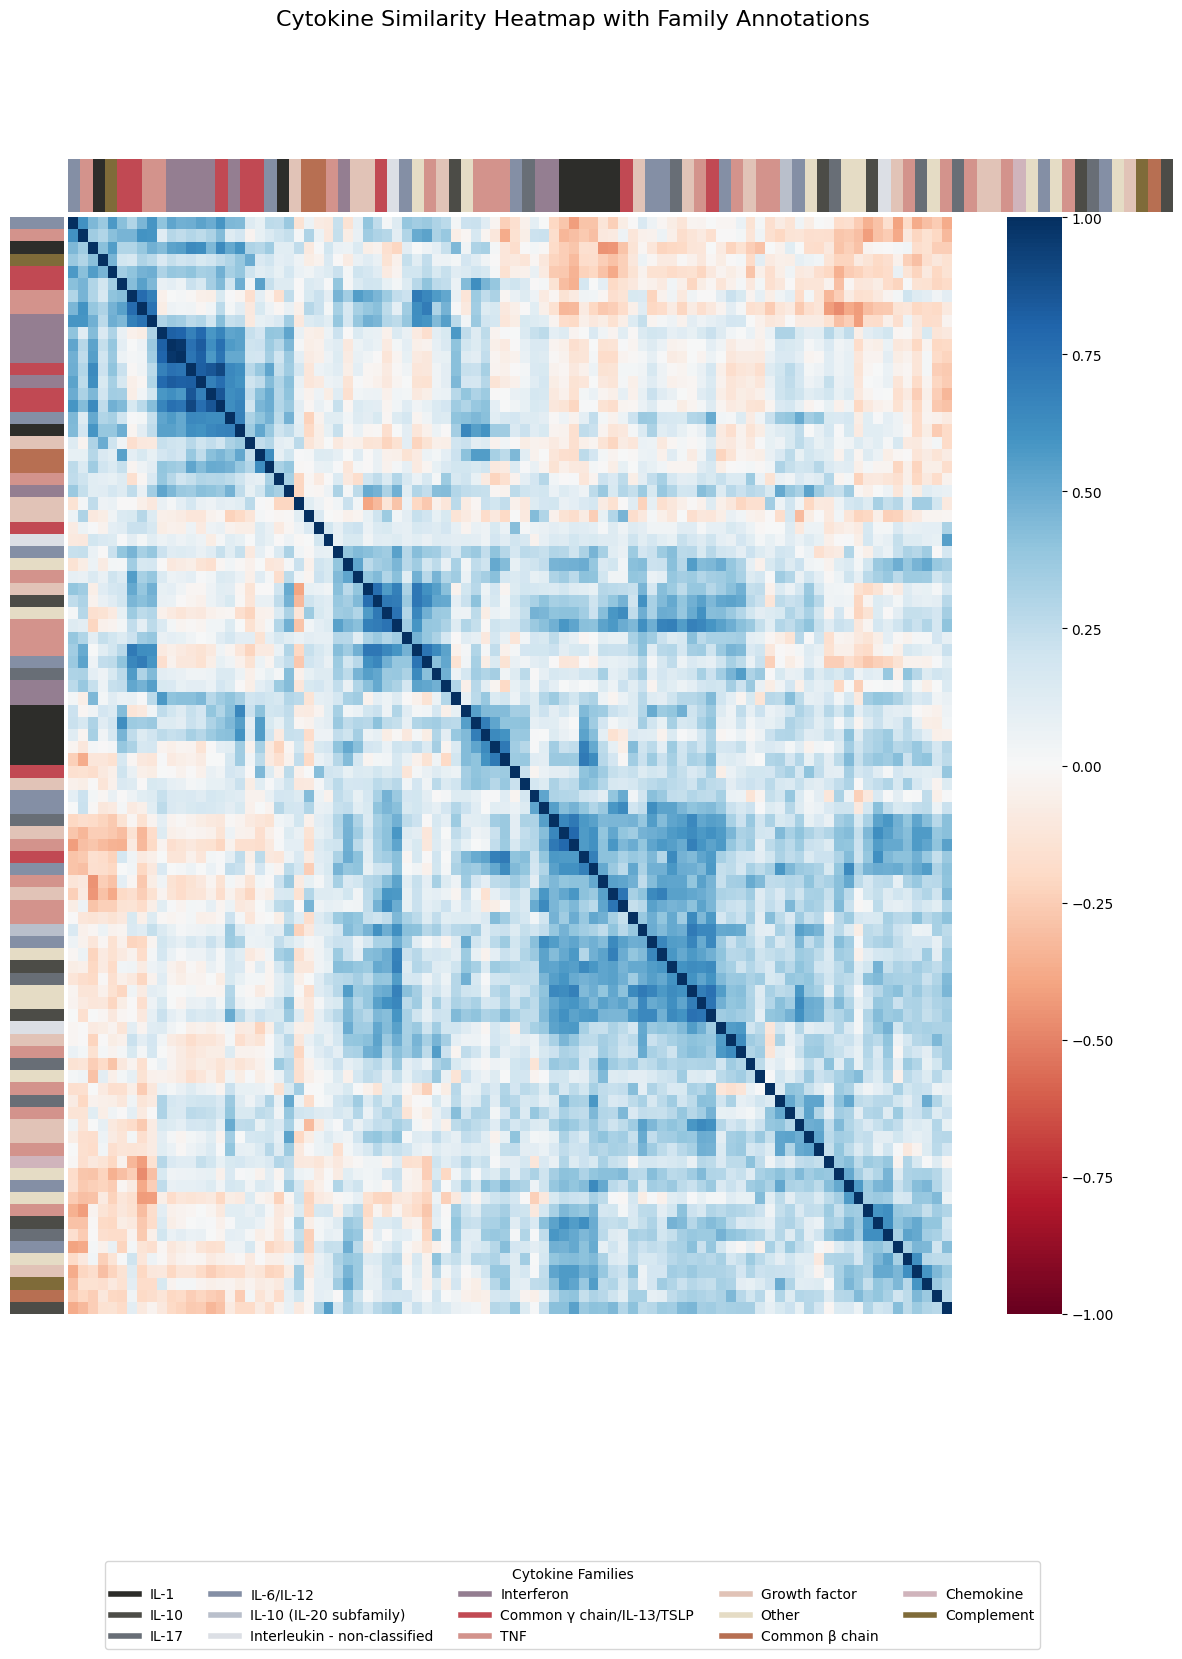

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

import matplotlib.colors as mcolors
family_to_color = {
    'IL-1': '#2D2D2A',
    'IL-10': '#4C4C47',
    'IL-17': '#686E76',
    'IL-6/IL-12': '#848FA5',
    'IL-10 (IL-20 subfamily)': '#B9BFCB',
    'Interleukin - non-classified': '#DCDFE5',
    'Interferon': '#947E91',
    'Common γ chain/IL-13/TSLP': '#C14953',
    'TNF': '#D3938C',
    'Growth factor': '#E1C3B7',
    'Other': '#E5DCC5',
    
    'Common β chain': '#B76F52',
    'Chemokine': '#D0B4BC',
    'Complement': '#7F6B39'
}

family_to_color = {k: mcolors.to_rgb(v) for k,v in family_to_color.items()}

# Map cytokines to colors
row_colors = [[family_to_color[cyto_to_family[cyto]]] for cyto in cyto_order]
col_colors = [family_to_color[cyto_to_family[cyto]] for cyto in cyto_order]

# Set up the grid
fig = plt.figure(figsize=(15, 15))
grid = fig.add_gridspec(20, 20, wspace=0.1, hspace=0.1)

# Main heatmap
ax_main = fig.add_subplot(grid[1:, 1:])
sns.heatmap(
    df_cytokine_sim.loc[cyto_order, cyto_order],
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=False,
    yticklabels=False,
    ax=ax_main,
)

# Row color bar
ax_row_colors = fig.add_subplot(grid[1:, 0])
ax_row_colors.imshow(row_colors, aspect="auto")
ax_row_colors.axis("off")

# Column color bar
ax_col_colors = fig.add_subplot(grid[0, 1:])
ax_col_colors.imshow([col_colors], aspect="auto")
ax_col_colors.axis("off")

# Add legend
legend_elements = [
    plt.Line2D([0], [0], color=color, lw=4, label=family)
    for family, color in family_to_color.items()
]
fig.legend(
    handles=legend_elements,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=5,
    title="Cytokine Families",
)

# Add a title
fig.suptitle("Cytokine Similarity Heatmap with Family Annotations", fontsize=16)
plt.savefig(os.path.join(output_dir, "cytokine_similarity_with_family_annotation.pdf"), format="pdf", bbox_inches="tight")

plt.show()


# Similarity for single donors

In [14]:
df_cytokine_sim_d1 = pd.DataFrame(index=cyto_order, columns=cyto_order)
d_to_consider = "Donor1"
for c1 in cyto_order:
    for c2 in cyto_order:
        repr_c1 = np.concatenate([donor_cytokine_displacements[d_to_consider][c1]], axis=1)
        repr_c2 = np.concatenate([donor_cytokine_displacements[d_to_consider][c2]], axis=1)
        df_cytokine_sim_d1.loc[c1, c2] = cosine_similarity(np.asarray(repr_c1), np.asarray(repr_c2))[0][0]

df_cytokine_sim_d1 = df_cytokine_sim_d1.astype("float")

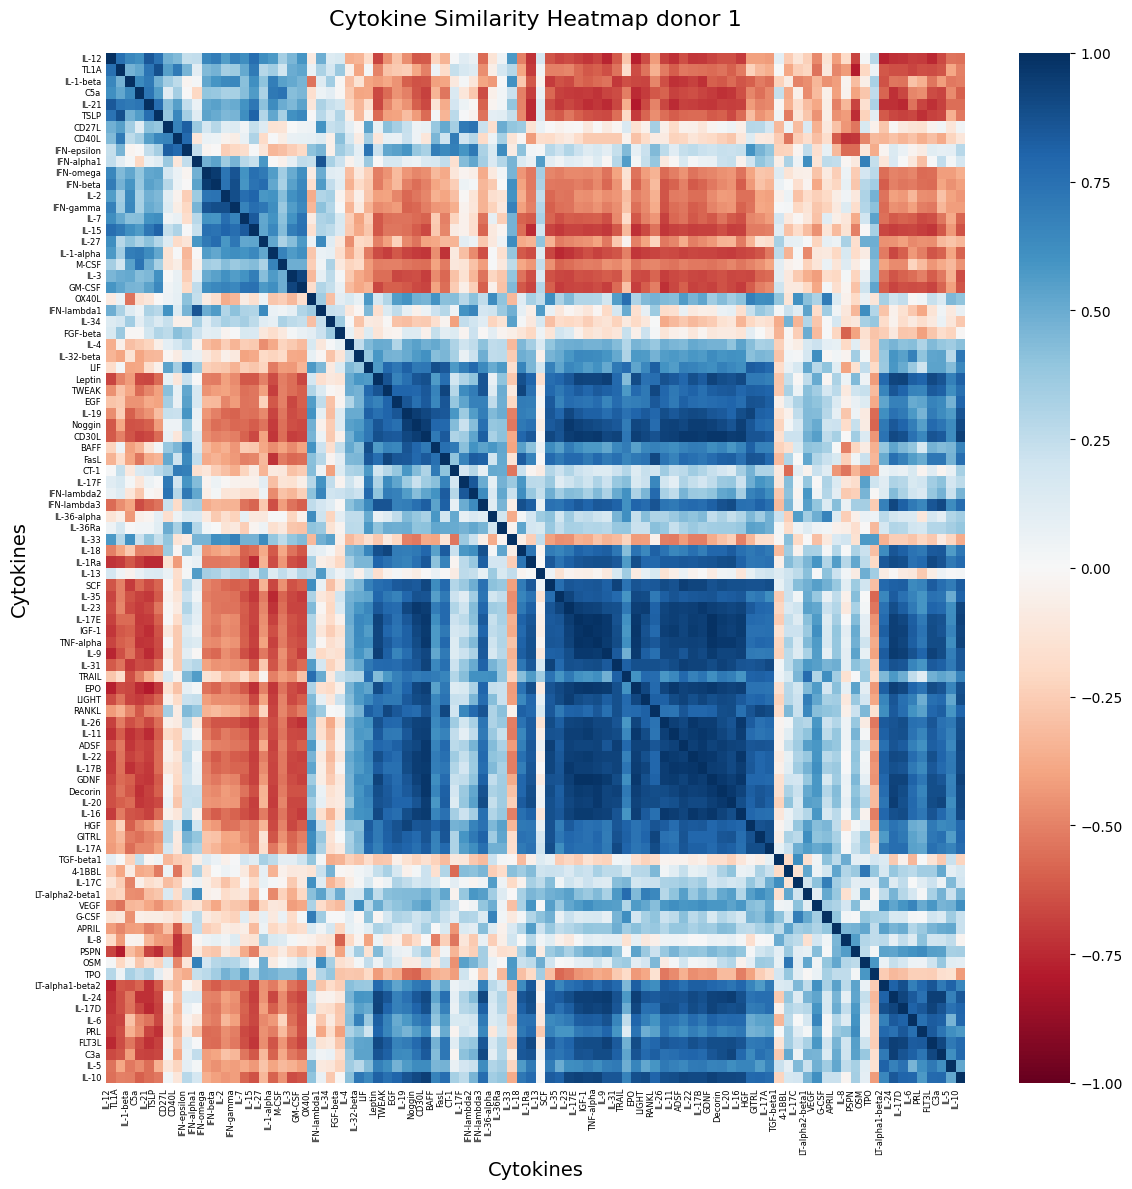

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size and style
plt.figure(figsize=(12, 12))  # Adjust width and height as needed

# Create the heatmap
sns.heatmap(
    df_cytokine_sim_d1.loc[cyto_order, cyto_order],
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,  # Ensure all x-axis labels are shown
    yticklabels=True,  # Ensure all y-axis labels are shown
    
)

# Add titles and labels
plt.title("Cytokine Similarity Heatmap donor 1", fontsize=16, pad=20)
plt.xlabel("Cytokines", fontsize=14)
plt.ylabel("Cytokines", fontsize=14)

# Adjust tick label size
plt.xticks(fontsize=6, rotation=90, ha="right")  # Rotate for better readability
plt.yticks(fontsize=6)
plt.tick_params(axis='x', which='both', length=0)  # Removes x-axis ticks but keeps labels
plt.tick_params(axis='y', which='both', length=0)  # Removes x-axis ticks but keeps labels

plt.savefig(os.path.join(output_dir, "cytokine_similarity_d1.pdf"), format="pdf", bbox_inches="tight")

# Show the heatmap
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


In [16]:
df_cytokine_sim_d2 = pd.DataFrame(index=cyto_order, columns=cyto_order)
d_to_consider = "Donor2"
for c1 in cyto_order:
    for c2 in cyto_order:
        repr_c1 = np.concatenate([donor_cytokine_displacements[d_to_consider][c1]], axis=1)
        repr_c2 = np.concatenate([donor_cytokine_displacements[d_to_consider][c2]], axis=1)
        df_cytokine_sim_d2.loc[c1, c2] = cosine_similarity(np.asarray(repr_c1), np.asarray(repr_c2))[0][0]

df_cytokine_sim_d2 = df_cytokine_sim_d2.astype("float")

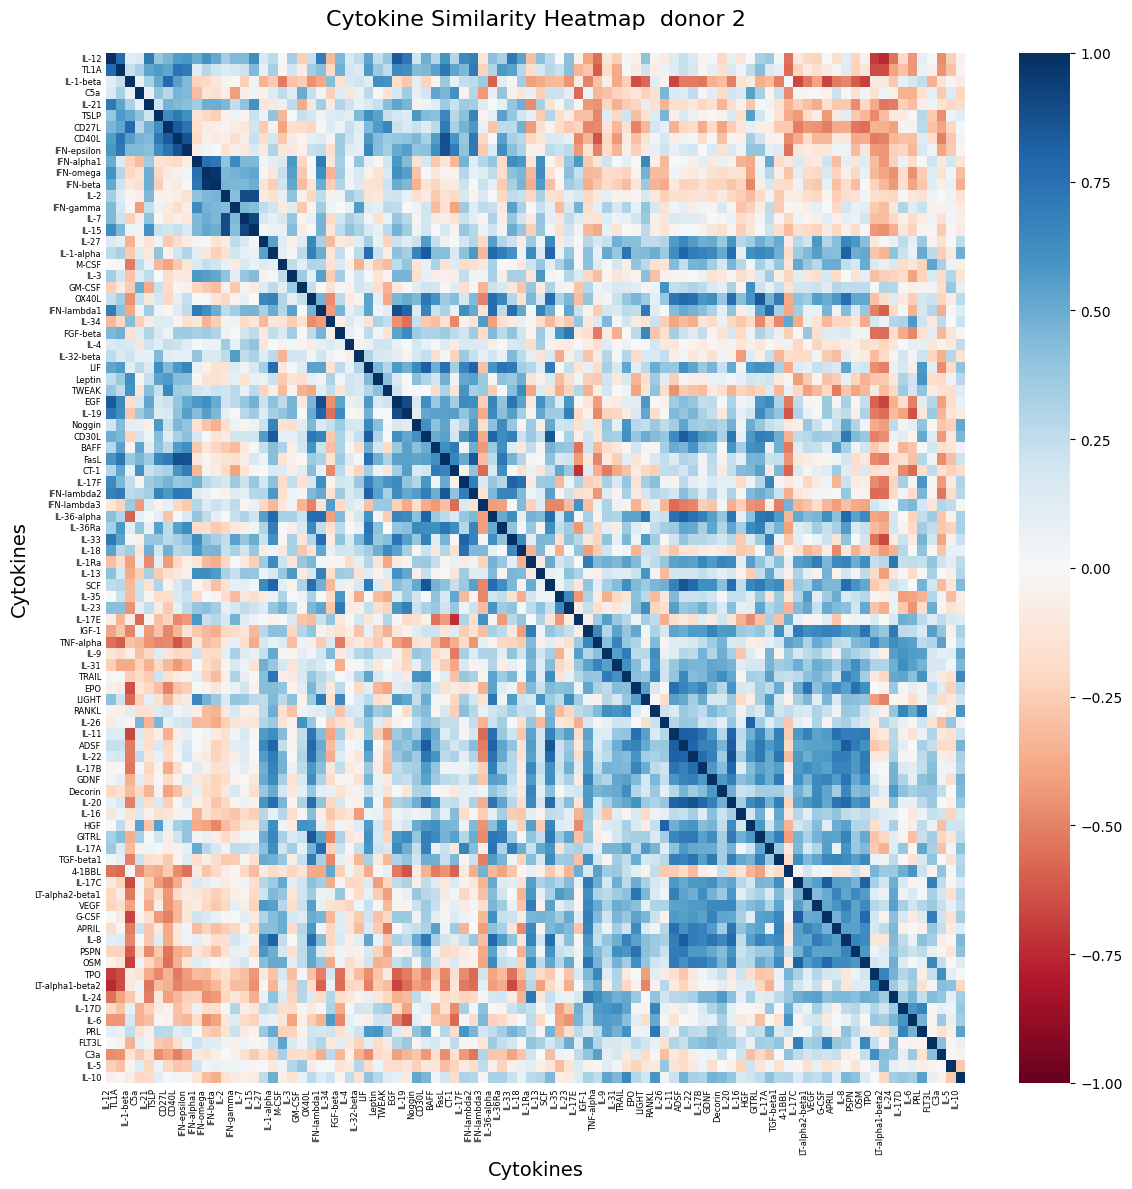

In [17]:
# Set the figure size and style
plt.figure(figsize=(12, 12))  # Adjust width and height as needed

# Create the heatmap
sns.heatmap(
    df_cytokine_sim_d2.loc[cyto_order, cyto_order],
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,  # Ensure all x-axis labels are shown
    yticklabels=True,  # Ensure all y-axis labels are shown
    
)

# Add titles and labels
plt.title("Cytokine Similarity Heatmap  donor 2", fontsize=16, pad=20)
plt.xlabel("Cytokines", fontsize=14)
plt.ylabel("Cytokines", fontsize=14)

# Adjust tick label size
plt.xticks(fontsize=6, rotation=90, ha="right")  # Rotate for better readability
plt.yticks(fontsize=6)
plt.tick_params(axis='x', which='both', length=0)  # Removes x-axis ticks but keeps labels
plt.tick_params(axis='y', which='both', length=0)  # Removes x-axis ticks but keeps labels

plt.savefig(os.path.join(output_dir, "cytokine_similarity_d2.pdf"), format="pdf", bbox_inches="tight")

# Show the heatmap
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


In [18]:
df_cytokine_sim_d3 = pd.DataFrame(index=cyto_order, columns=cyto_order)
d_to_consider = "Donor3"
for c1 in cyto_order:
    for c2 in cyto_order:
        repr_c1 = np.concatenate([donor_cytokine_displacements[d_to_consider][c1]], axis=1)
        repr_c2 = np.concatenate([donor_cytokine_displacements[d_to_consider][c2]], axis=1)
        df_cytokine_sim_d3.loc[c1, c2] = cosine_similarity(np.asarray(repr_c1), np.asarray(repr_c2))[0][0]

df_cytokine_sim_d3 = df_cytokine_sim_d3.astype("float")

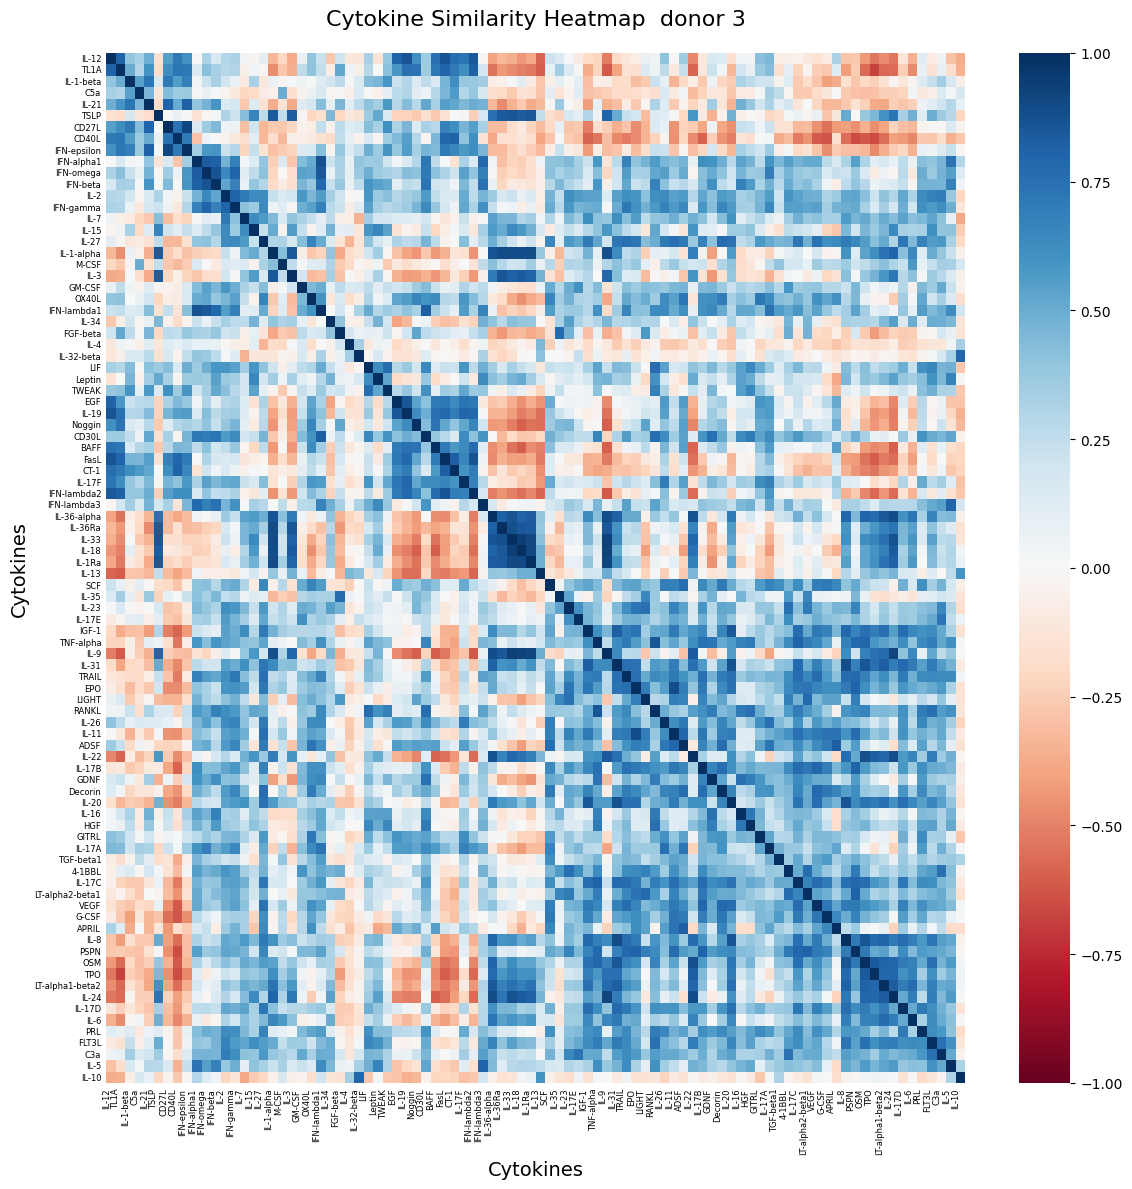

In [19]:
# Set the figure size and style
plt.figure(figsize=(12, 12))  # Adjust width and height as needed

# Create the heatmap
sns.heatmap(
    df_cytokine_sim_d3.loc[cyto_order, cyto_order],
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,  # Ensure all x-axis labels are shown
    yticklabels=True,  # Ensure all y-axis labels are shown
    
)

# Add titles and labels
plt.title("Cytokine Similarity Heatmap  donor 3", fontsize=16, pad=20)
plt.xlabel("Cytokines", fontsize=14)
plt.ylabel("Cytokines", fontsize=14)

# Adjust tick label size
plt.xticks(fontsize=6, rotation=90, ha="right")  # Rotate for better readability
plt.yticks(fontsize=6)
plt.tick_params(axis='x', which='both', length=0)  # Removes x-axis ticks but keeps labels
plt.tick_params(axis='y', which='both', length=0)  # Removes x-axis ticks but keeps labels

plt.savefig(os.path.join(output_dir, "cytokine_similarity_d3.pdf"), format="pdf", bbox_inches="tight")

# Show the heatmap
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


In [20]:
df_cytokine_sim_d4 = pd.DataFrame(index=cyto_order, columns=cyto_order)
d_to_consider = "Donor4"
for c1 in cyto_order:
    for c2 in cyto_order:
        repr_c1 = np.concatenate([donor_cytokine_displacements[d_to_consider][c1]], axis=1)
        repr_c2 = np.concatenate([donor_cytokine_displacements[d_to_consider][c2]], axis=1)
        df_cytokine_sim_d4.loc[c1, c2] = cosine_similarity(np.asarray(repr_c1), np.asarray(repr_c2))[0][0]

df_cytokine_sim_d4 = df_cytokine_sim_d4.astype("float")

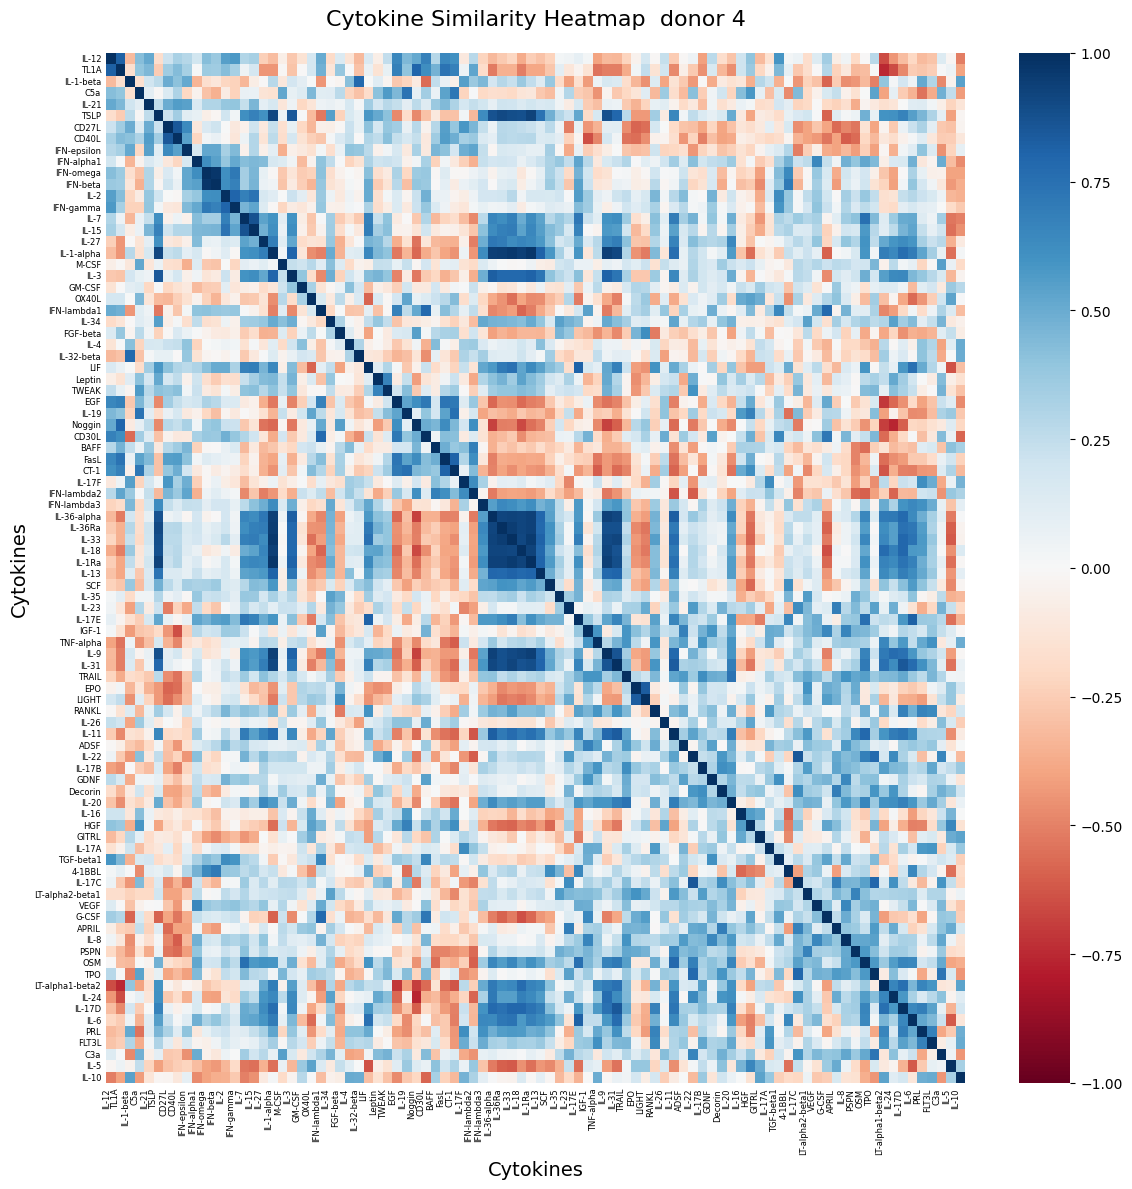

In [21]:
# Set the figure size and style
plt.figure(figsize=(12, 12))  # Adjust width and height as needed

# Create the heatmap
sns.heatmap(
    df_cytokine_sim_d4.loc[cyto_order, cyto_order],
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,  # Ensure all x-axis labels are shown
    yticklabels=True,  # Ensure all y-axis labels are shown
    
)

# Add titles and labels
plt.title("Cytokine Similarity Heatmap  donor 4", fontsize=16, pad=20)
plt.xlabel("Cytokines", fontsize=14)
plt.ylabel("Cytokines", fontsize=14)

# Adjust tick label size
plt.xticks(fontsize=6, rotation=90, ha="right")  # Rotate for better readability
plt.yticks(fontsize=6)
plt.tick_params(axis='x', which='both', length=0)  # Removes x-axis ticks but keeps labels
plt.tick_params(axis='y', which='both', length=0)  # Removes x-axis ticks but keeps labels

plt.savefig(os.path.join(output_dir, "cytokine_similarity_d4.pdf"), format="pdf", bbox_inches="tight")

# Show the heatmap
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


In [22]:
df_cytokine_sim_d5 = pd.DataFrame(index=cyto_order, columns=cyto_order)
d_to_consider = "Donor5"
for c1 in cyto_order:
    for c2 in cyto_order:
        repr_c1 = np.concatenate([donor_cytokine_displacements[d_to_consider][c1]], axis=1)
        repr_c2 = np.concatenate([donor_cytokine_displacements[d_to_consider][c2]], axis=1)
        df_cytokine_sim_d5.loc[c1, c2] = cosine_similarity(np.asarray(repr_c1), np.asarray(repr_c2))[0][0]

df_cytokine_sim_d5 = df_cytokine_sim_d5.astype("float")

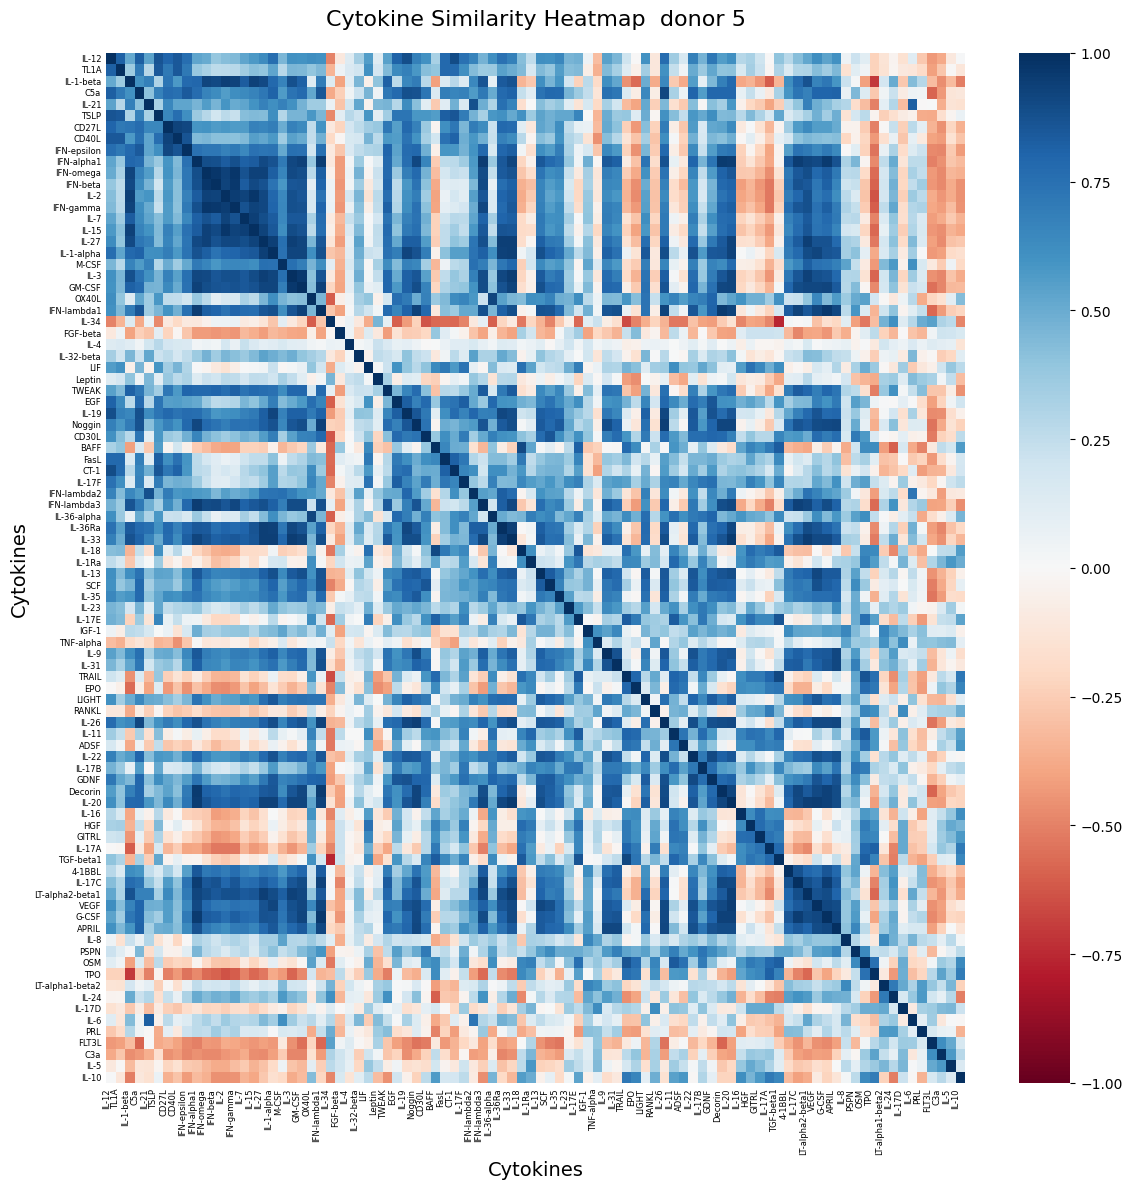

In [23]:
# Set the figure size and style
plt.figure(figsize=(12, 12))  # Adjust width and height as needed

# Create the heatmap
sns.heatmap(
    df_cytokine_sim_d5.loc[cyto_order, cyto_order],
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,  # Ensure all x-axis labels are shown
    yticklabels=True,  # Ensure all y-axis labels are shown
    
)

# Add titles and labels
plt.title("Cytokine Similarity Heatmap  donor 5", fontsize=16, pad=20)
plt.xlabel("Cytokines", fontsize=14)
plt.ylabel("Cytokines", fontsize=14)

# Adjust tick label size
plt.xticks(fontsize=6, rotation=90, ha="right")  # Rotate for better readability
plt.yticks(fontsize=6)
plt.tick_params(axis='x', which='both', length=0)  # Removes x-axis ticks but keeps labels
plt.tick_params(axis='y', which='both', length=0)  # Removes x-axis ticks but keeps labels

plt.savefig(os.path.join(output_dir, "cytokine_similarity_d5.pdf"), format="pdf", bbox_inches="tight")

# Show the heatmap
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


In [24]:
df_cytokine_sim_d6 = pd.DataFrame(index=cyto_order, columns=cyto_order)
d_to_consider = "Donor6"
for c1 in cyto_order:
    for c2 in cyto_order:
        repr_c1 = np.concatenate([donor_cytokine_displacements[d_to_consider][c1]], axis=1)
        repr_c2 = np.concatenate([donor_cytokine_displacements[d_to_consider][c2]], axis=1)
        df_cytokine_sim_d6.loc[c1, c2] = cosine_similarity(np.asarray(repr_c1), np.asarray(repr_c2))[0][0]

df_cytokine_sim_d6 = df_cytokine_sim_d6.astype("float")

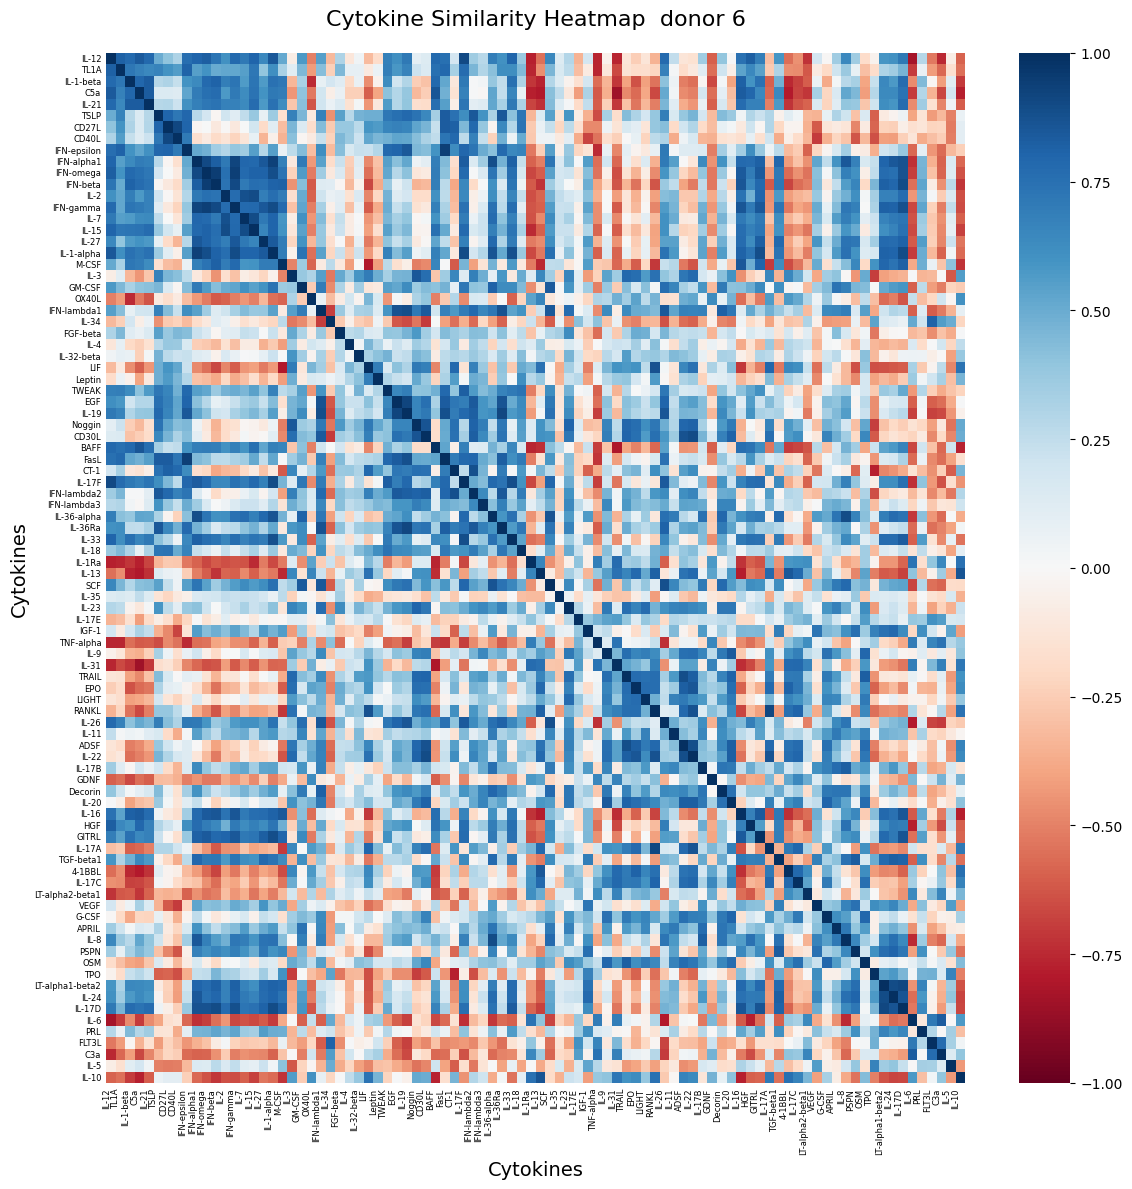

In [25]:
# Set the figure size and style
plt.figure(figsize=(12, 12))  # Adjust width and height as needed

# Create the heatmap
sns.heatmap(
    df_cytokine_sim_d6.loc[cyto_order, cyto_order],
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,  # Ensure all x-axis labels are shown
    yticklabels=True,  # Ensure all y-axis labels are shown
    
)

# Add titles and labels
plt.title("Cytokine Similarity Heatmap  donor 6", fontsize=16, pad=20)
plt.xlabel("Cytokines", fontsize=14)
plt.ylabel("Cytokines", fontsize=14)

# Adjust tick label size
plt.xticks(fontsize=6, rotation=90, ha="right")  # Rotate for better readability
plt.yticks(fontsize=6)
plt.tick_params(axis='x', which='both', length=0)  # Removes x-axis ticks but keeps labels
plt.tick_params(axis='y', which='both', length=0)  # Removes x-axis ticks but keeps labels

plt.savefig(os.path.join(output_dir, "cytokine_similarity_d6.pdf"), format="pdf", bbox_inches="tight")

# Show the heatmap
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


In [26]:
df_cytokine_sim_d7 = pd.DataFrame(index=cyto_order, columns=cyto_order)
d_to_consider = "Donor7"
for c1 in cyto_order:
    for c2 in cyto_order:
        repr_c1 = np.concatenate([donor_cytokine_displacements[d_to_consider][c1]], axis=1)
        repr_c2 = np.concatenate([donor_cytokine_displacements[d_to_consider][c2]], axis=1)
        df_cytokine_sim_d7.loc[c1, c2] = cosine_similarity(np.asarray(repr_c1), np.asarray(repr_c2))[0][0]

df_cytokine_sim_d7 = df_cytokine_sim_d7.astype("float")

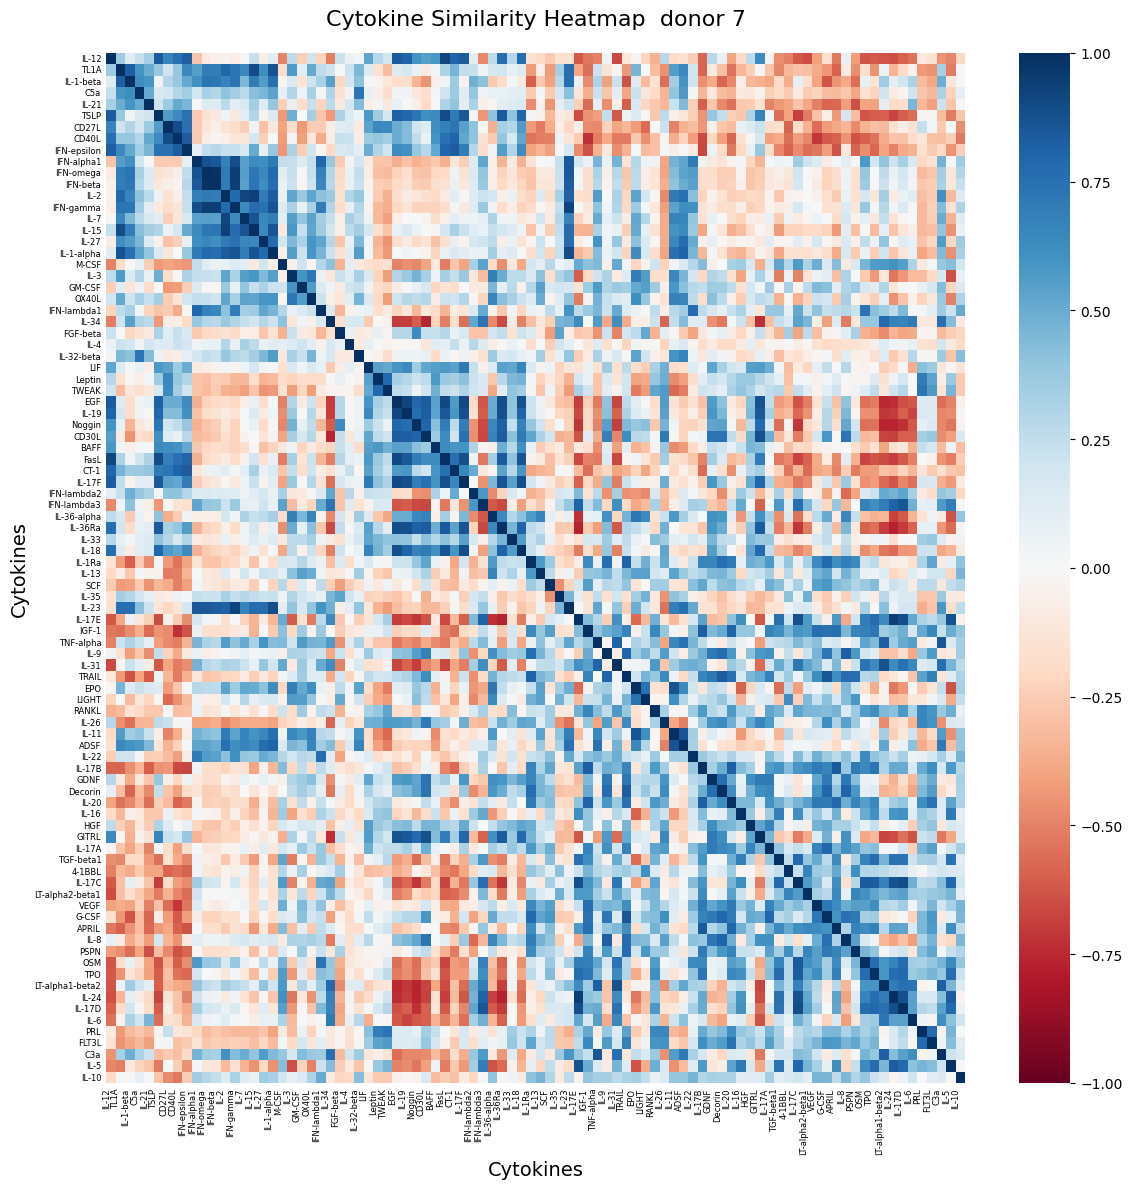

In [27]:
# Set the figure size and style
plt.figure(figsize=(12, 12))  # Adjust width and height as needed

# Create the heatmap
sns.heatmap(
    df_cytokine_sim_d7.loc[cyto_order, cyto_order],
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,  # Ensure all x-axis labels are shown
    yticklabels=True,  # Ensure all y-axis labels are shown
    
)

# Add titles and labels
plt.title("Cytokine Similarity Heatmap  donor 7", fontsize=16, pad=20)
plt.xlabel("Cytokines", fontsize=14)
plt.ylabel("Cytokines", fontsize=14)

# Adjust tick label size
plt.xticks(fontsize=6, rotation=90, ha="right")  # Rotate for better readability
plt.yticks(fontsize=6)
plt.tick_params(axis='x', which='both', length=0)  # Removes x-axis ticks but keeps labels
plt.tick_params(axis='y', which='both', length=0)  # Removes x-axis ticks but keeps labels

plt.savefig(os.path.join(output_dir, "cytokine_similarity_d7.pdf"), format="pdf", bbox_inches="tight")

# Show the heatmap
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


In [28]:
df_cytokine_sim_d8 = pd.DataFrame(index=cyto_order, columns=cyto_order)
d_to_consider = "Donor8"
for c1 in cyto_order:
    for c2 in cyto_order:
        repr_c1 = np.concatenate([donor_cytokine_displacements[d_to_consider][c1]], axis=1)
        repr_c2 = np.concatenate([donor_cytokine_displacements[d_to_consider][c2]], axis=1)
        df_cytokine_sim_d8.loc[c1, c2] = cosine_similarity(np.asarray(repr_c1), np.asarray(repr_c2))[0][0]

df_cytokine_sim_d8 = df_cytokine_sim_d8.astype("float")

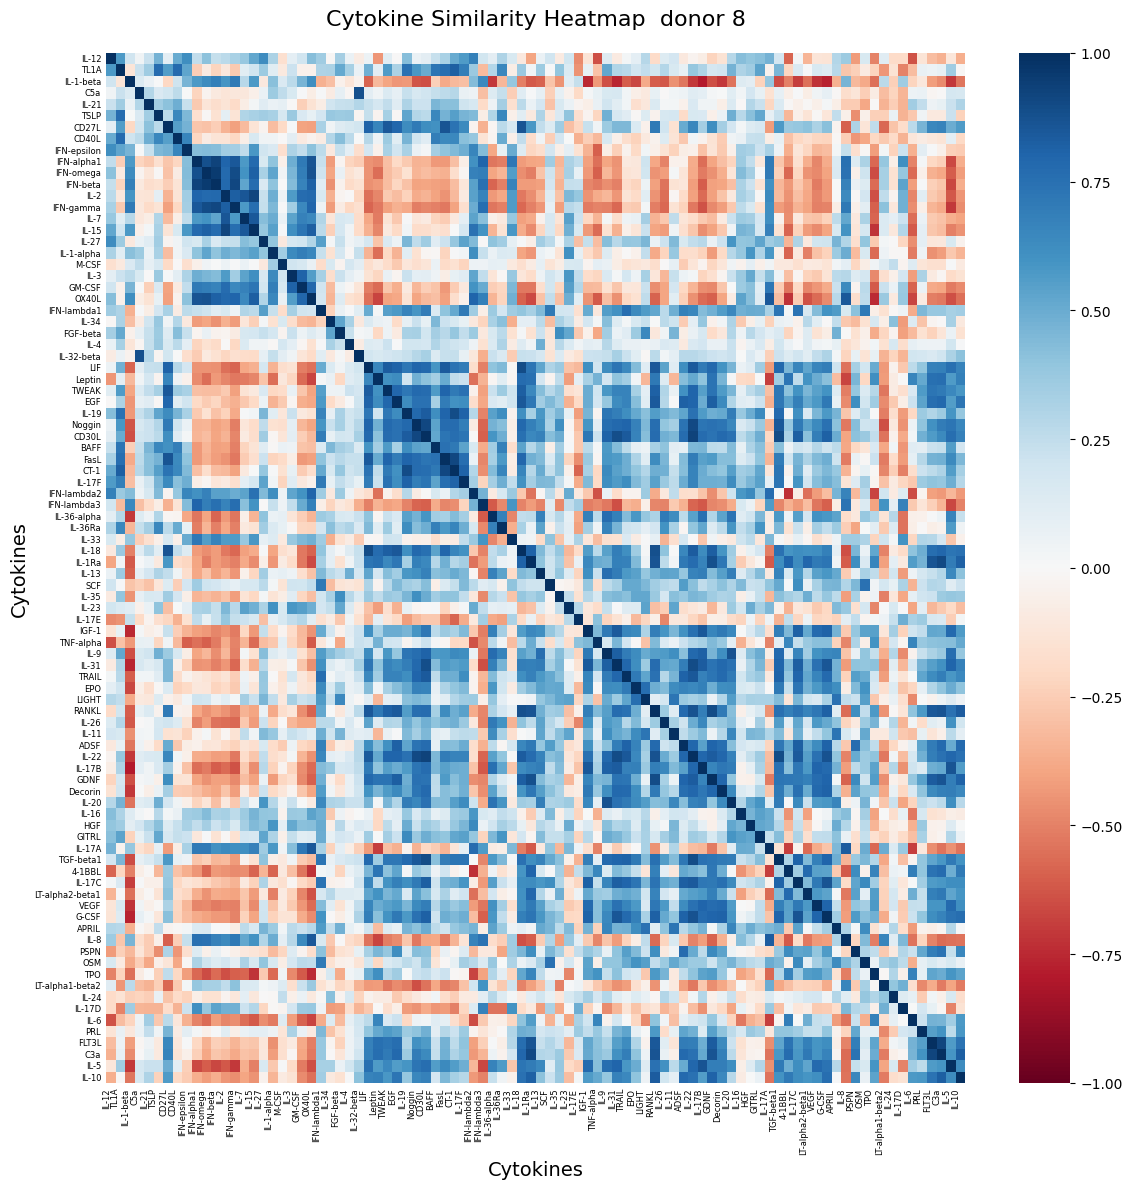

In [29]:
# Set the figure size and style
plt.figure(figsize=(12, 12))  # Adjust width and height as needed

# Create the heatmap
sns.heatmap(
    df_cytokine_sim_d8.loc[cyto_order, cyto_order],
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,  # Ensure all x-axis labels are shown
    yticklabels=True,  # Ensure all y-axis labels are shown
    
)

# Add titles and labels
plt.title("Cytokine Similarity Heatmap  donor 8", fontsize=16, pad=20)
plt.xlabel("Cytokines", fontsize=14)
plt.ylabel("Cytokines", fontsize=14)

# Adjust tick label size
plt.xticks(fontsize=6, rotation=90, ha="right")  # Rotate for better readability
plt.yticks(fontsize=6)
plt.tick_params(axis='x', which='both', length=0)  # Removes x-axis ticks but keeps labels
plt.tick_params(axis='y', which='both', length=0)  # Removes x-axis ticks but keeps labels

plt.savefig(os.path.join(output_dir, "cytokine_similarity_d8.pdf"), format="pdf", bbox_inches="tight")

# Show the heatmap
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


In [30]:
df_cytokine_sim_d9 = pd.DataFrame(index=cyto_order, columns=cyto_order)
d_to_consider = "Donor9"
for c1 in cyto_order:
    for c2 in cyto_order:
        repr_c1 = np.concatenate([donor_cytokine_displacements[d_to_consider][c1]], axis=1)
        repr_c2 = np.concatenate([donor_cytokine_displacements[d_to_consider][c2]], axis=1)
        df_cytokine_sim_d9.loc[c1, c2] = cosine_similarity(np.asarray(repr_c1), np.asarray(repr_c2))[0][0]

df_cytokine_sim_d9 = df_cytokine_sim_d9.astype("float")

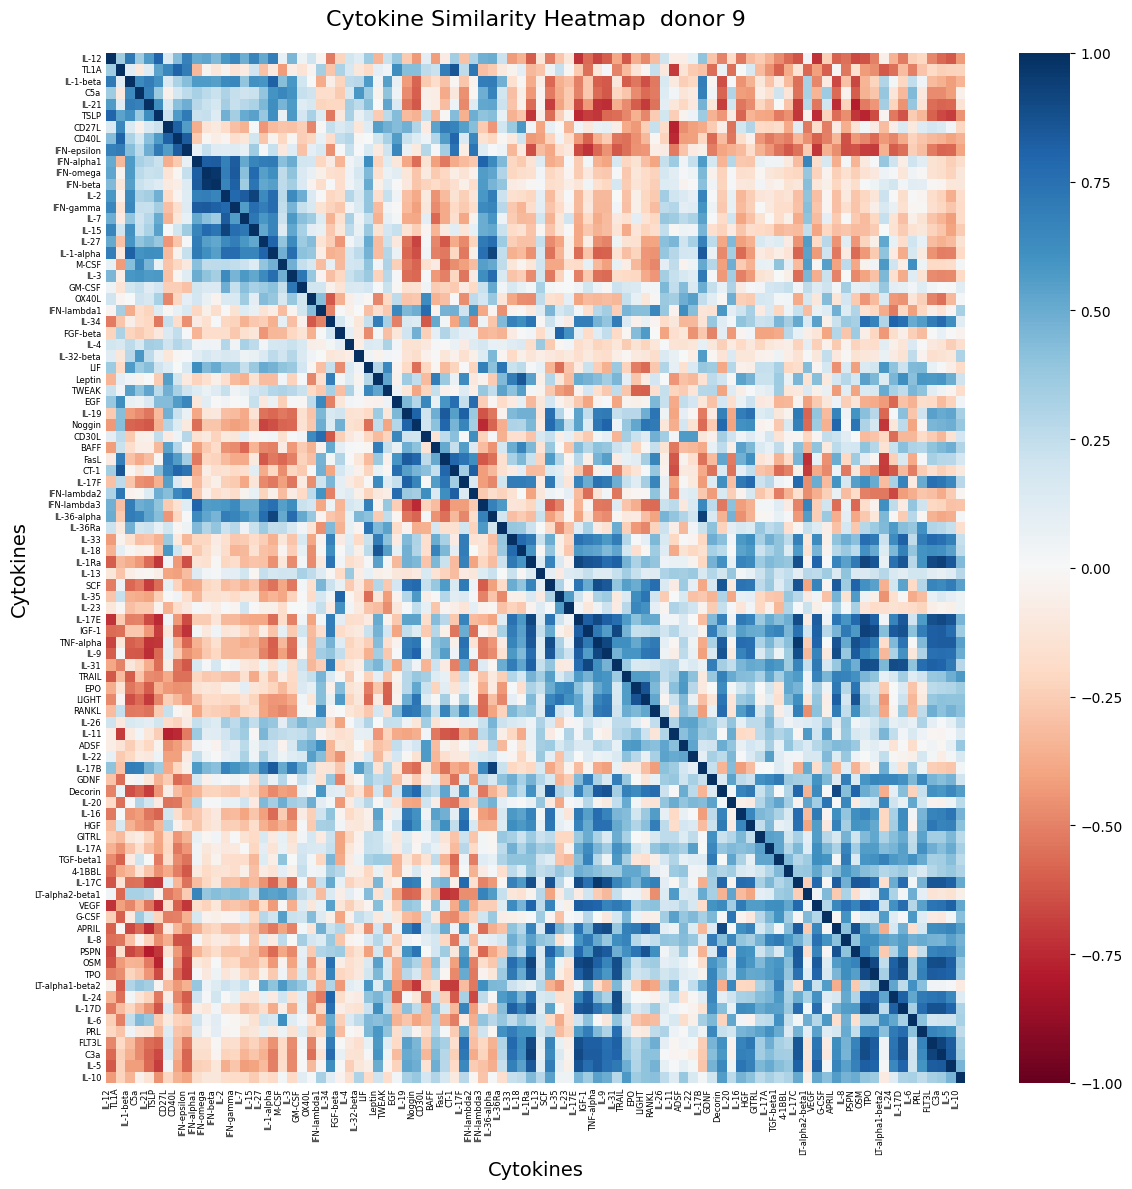

In [31]:
# Set the figure size and style
plt.figure(figsize=(12, 12))  # Adjust width and height as needed

# Create the heatmap
sns.heatmap(
    df_cytokine_sim_d9.loc[cyto_order, cyto_order],
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,  # Ensure all x-axis labels are shown
    yticklabels=True,  # Ensure all y-axis labels are shown
    
)

# Add titles and labels
plt.title("Cytokine Similarity Heatmap  donor 9", fontsize=16, pad=20)
plt.xlabel("Cytokines", fontsize=14)
plt.ylabel("Cytokines", fontsize=14)

# Adjust tick label size
plt.xticks(fontsize=6, rotation=90, ha="right")  # Rotate for better readability
plt.yticks(fontsize=6)
plt.tick_params(axis='x', which='both', length=0)  # Removes x-axis ticks but keeps labels
plt.tick_params(axis='y', which='both', length=0)  # Removes x-axis ticks but keeps labels

plt.savefig(os.path.join(output_dir, "cytokine_similarity_d9.pdf"), format="pdf", bbox_inches="tight")

# Show the heatmap
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


In [32]:
df_cytokine_sim_d10 = pd.DataFrame(index=cyto_order, columns=cyto_order)
d_to_consider = "Donor10"
for c1 in cyto_order:
    for c2 in cyto_order:
        repr_c1 = np.concatenate([donor_cytokine_displacements[d_to_consider][c1]], axis=1)
        repr_c2 = np.concatenate([donor_cytokine_displacements[d_to_consider][c2]], axis=1)
        df_cytokine_sim_d10.loc[c1, c2] = cosine_similarity(np.asarray(repr_c1), np.asarray(repr_c2))[0][0]

df_cytokine_sim_d10 = df_cytokine_sim_d10.astype("float")

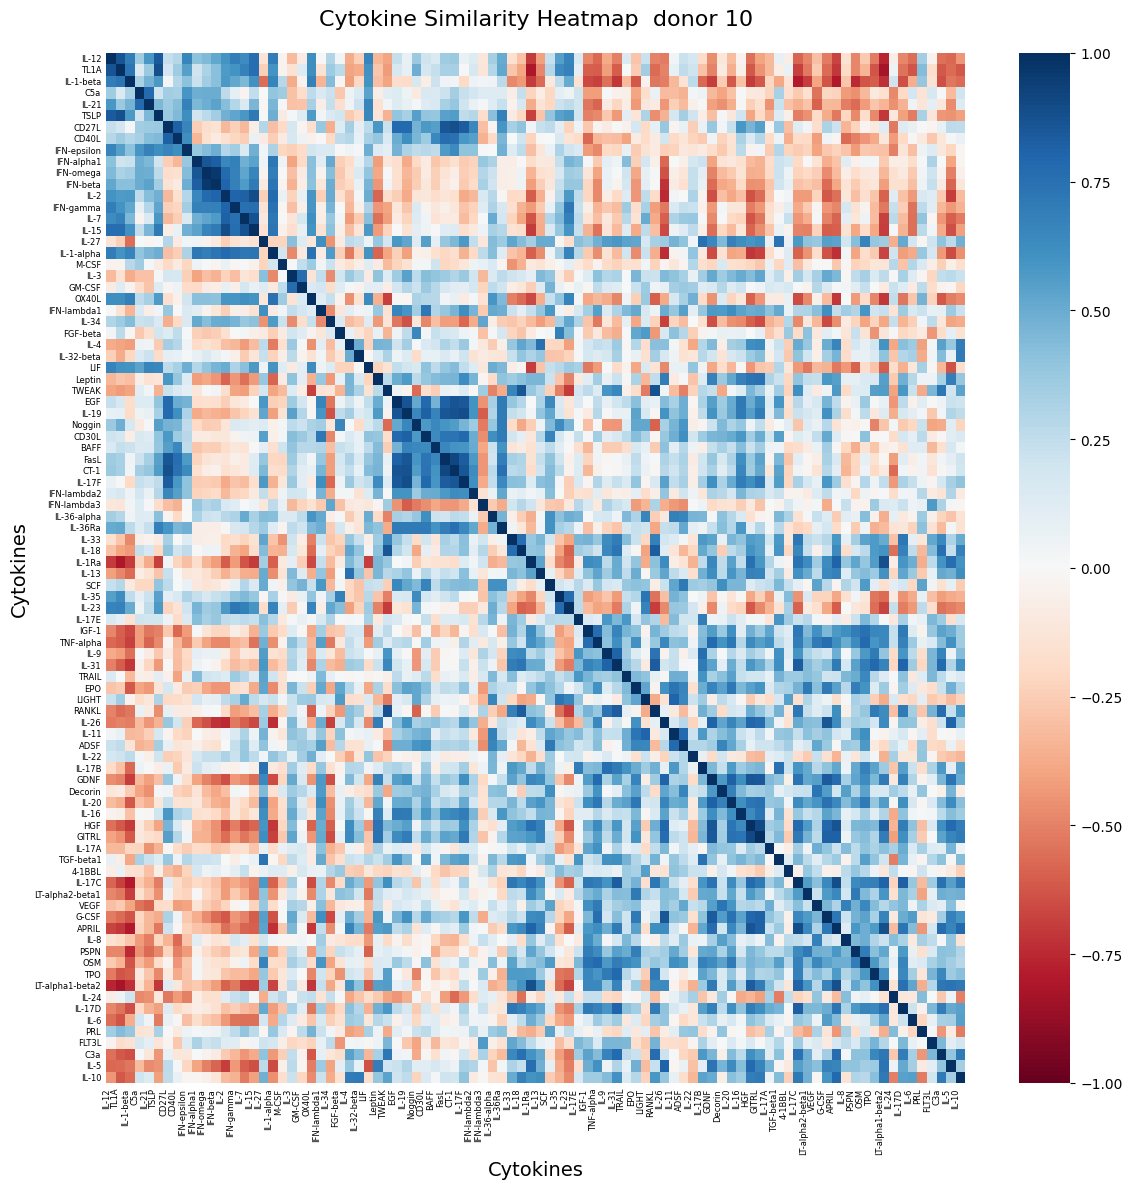

In [33]:
# Set the figure size and style
plt.figure(figsize=(12, 12))  # Adjust width and height as needed

# Create the heatmap
sns.heatmap(
    df_cytokine_sim_d10.loc[cyto_order, cyto_order],
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,  # Ensure all x-axis labels are shown
    yticklabels=True,  # Ensure all y-axis labels are shown
    
)

# Add titles and labels
plt.title("Cytokine Similarity Heatmap  donor 10", fontsize=16, pad=20)
plt.xlabel("Cytokines", fontsize=14)
plt.ylabel("Cytokines", fontsize=14)

# Adjust tick label size
plt.xticks(fontsize=6, rotation=90, ha="right")  # Rotate for better readability
plt.yticks(fontsize=6)
plt.tick_params(axis='x', which='both', length=0)  # Removes x-axis ticks but keeps labels
plt.tick_params(axis='y', which='both', length=0)  # Removes x-axis ticks but keeps labels

plt.savefig(os.path.join(output_dir, "cytokine_similarity_d10.pdf"), format="pdf", bbox_inches="tight")

# Show the heatmap
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


In [34]:
df_cytokine_sim_d11 = pd.DataFrame(index=cyto_order, columns=cyto_order)
d_to_consider = "Donor11"
for c1 in cyto_order:
    for c2 in cyto_order:
        repr_c1 = np.concatenate([donor_cytokine_displacements[d_to_consider][c1]], axis=1)
        repr_c2 = np.concatenate([donor_cytokine_displacements[d_to_consider][c2]], axis=1)
        df_cytokine_sim_d11.loc[c1, c2] = cosine_similarity(np.asarray(repr_c1), np.asarray(repr_c2))[0][0]

df_cytokine_sim_d11 = df_cytokine_sim_d11.astype("float")

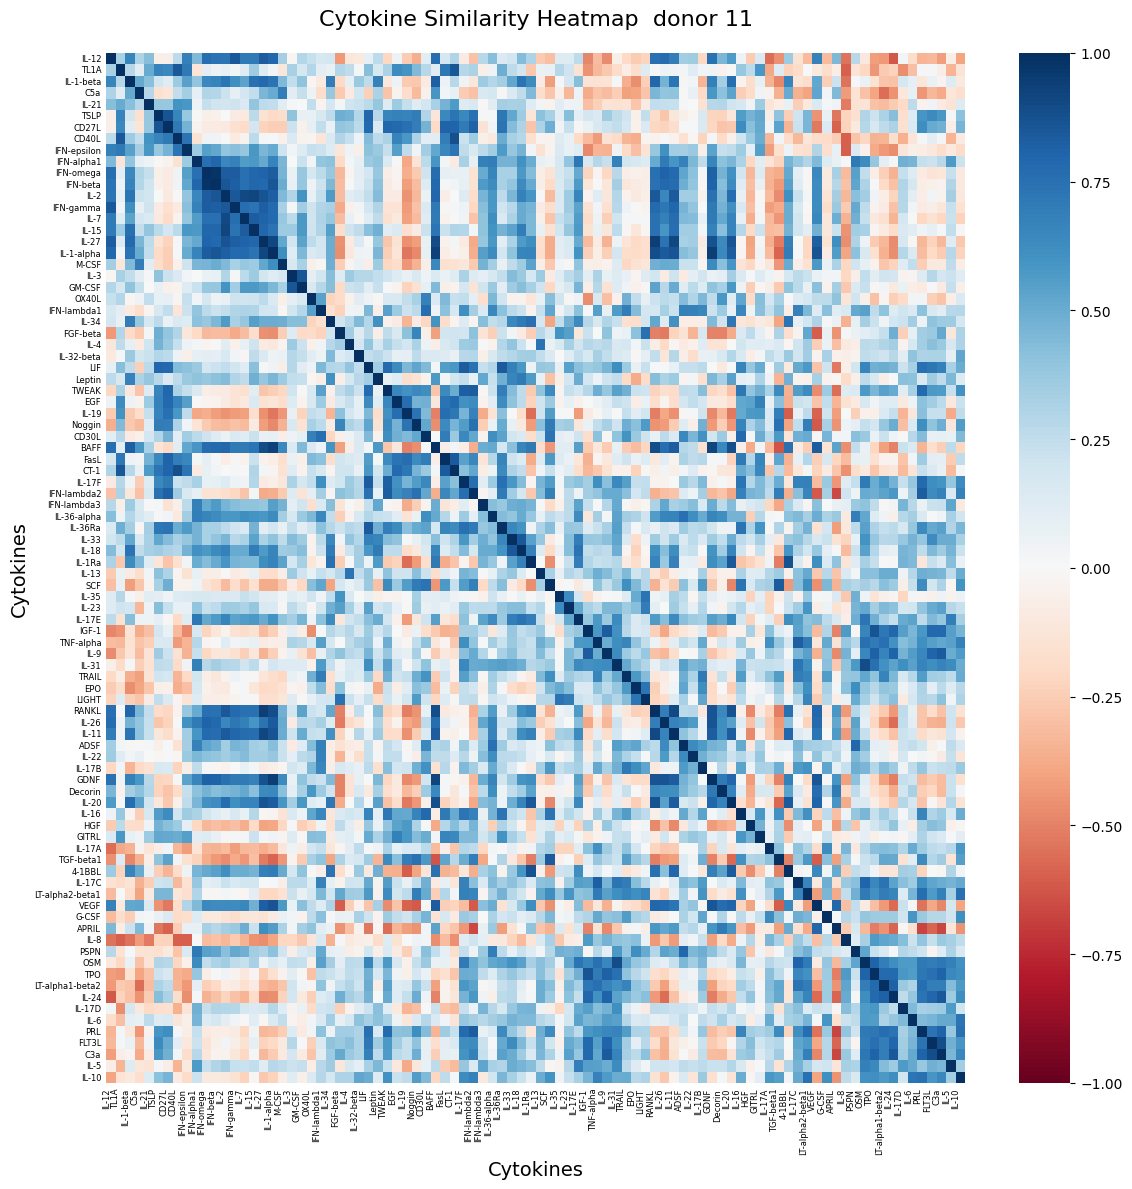

In [35]:
# Set the figure size and style
plt.figure(figsize=(12, 12))  # Adjust width and height as needed

# Create the heatmap
sns.heatmap(
    df_cytokine_sim_d11.loc[cyto_order, cyto_order],
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,  # Ensure all x-axis labels are shown
    yticklabels=True,  # Ensure all y-axis labels are shown
    
)

# Add titles and labels
plt.title("Cytokine Similarity Heatmap  donor 11", fontsize=16, pad=20)
plt.xlabel("Cytokines", fontsize=14)
plt.ylabel("Cytokines", fontsize=14)

# Adjust tick label size
plt.xticks(fontsize=6, rotation=90, ha="right")  # Rotate for better readability
plt.yticks(fontsize=6)
plt.tick_params(axis='x', which='both', length=0)  # Removes x-axis ticks but keeps labels
plt.tick_params(axis='y', which='both', length=0)  # Removes x-axis ticks but keeps labels

plt.savefig(os.path.join(output_dir, "cytokine_similarity_d11.pdf"), format="pdf", bbox_inches="tight")

# Show the heatmap
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


In [36]:
df_cytokine_sim_d12 = pd.DataFrame(index=cyto_order, columns=cyto_order)
d_to_consider = "Donor12"
for c1 in cyto_order:
    for c2 in cyto_order:
        repr_c1 = np.concatenate([donor_cytokine_displacements[d_to_consider][c1]], axis=1)
        repr_c2 = np.concatenate([donor_cytokine_displacements[d_to_consider][c2]], axis=1)
        df_cytokine_sim_d12.loc[c1, c2] = cosine_similarity(np.asarray(repr_c1), np.asarray(repr_c2))[0][0]

df_cytokine_sim_d12 = df_cytokine_sim_d12.astype("float")

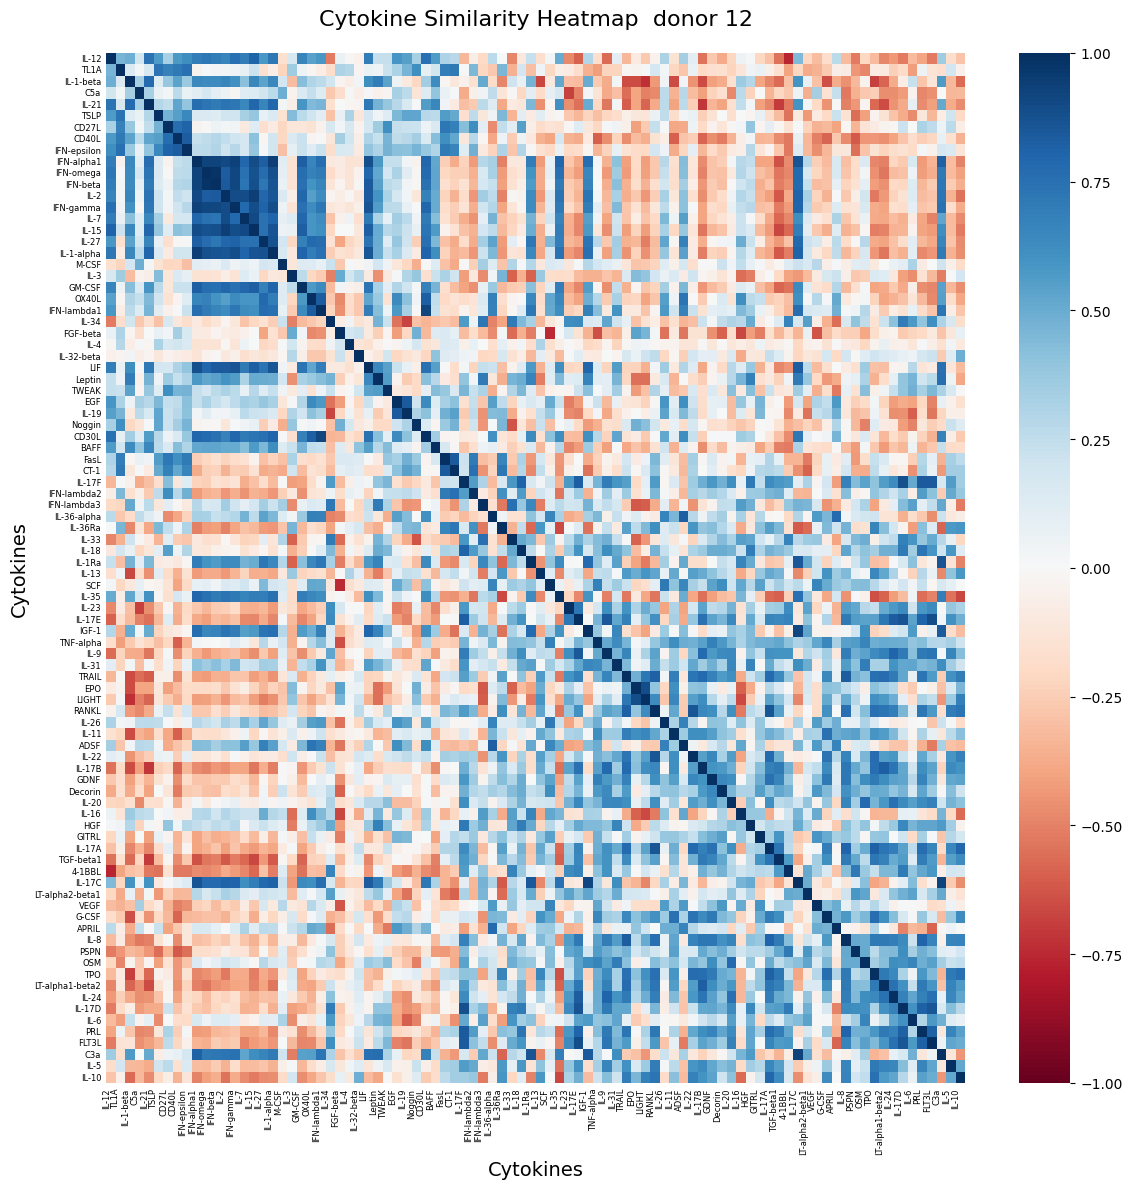

In [37]:
# Set the figure size and style
plt.figure(figsize=(12, 12))  # Adjust width and height as needed

# Create the heatmap
sns.heatmap(
    df_cytokine_sim_d12.loc[cyto_order, cyto_order],
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,  # Ensure all x-axis labels are shown
    yticklabels=True,  # Ensure all y-axis labels are shown
    
)

# Add titles and labels
plt.title("Cytokine Similarity Heatmap  donor 12", fontsize=16, pad=20)
plt.xlabel("Cytokines", fontsize=14)
plt.ylabel("Cytokines", fontsize=14)

# Adjust tick label size
plt.xticks(fontsize=6, rotation=90, ha="right")  # Rotate for better readability
plt.yticks(fontsize=6)
plt.tick_params(axis='x', which='both', length=0)  # Removes x-axis ticks but keeps labels
plt.tick_params(axis='y', which='both', length=0)  # Removes x-axis ticks but keeps labels

plt.savefig(os.path.join(output_dir, "cytokine_similarity_d12.pdf"), format="pdf", bbox_inches="tight")

# Show the heatmap
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()
